# PUBG predict chance of winning a game - Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./train_V2.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939739 entries, 0 to 2939738
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         float64
revives            float64
rideDistance       float64
roadKills          float64
swimDistance       float64
teamKills          float64
vehicleDestroys    float64
walkDistance       float64
weaponsAcquired    float64
winPoints          float64
winPlacePerc       float64
dtypes: float64(13), int64(12), object(4)
memory usage: 650.4+ MB


In [4]:
def downcast_dtypes(df):

	# Select columns to downcast
	float_cols = [c for c in df if df[c].dtype == "float64"]
	int_cols =   [c for c in df if df[c].dtype == "int64"]

	# Downcast
	df[float_cols] = df[float_cols].astype(np.float32)
	df[int_cols]   = df[int_cols].astype(np.int32)

	return df

In [5]:
train = downcast_dtypes(train)

### Feature description (from Kaggle)

* groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

* matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs - Number of enemy players knocked.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
* kills - Number of enemy players killed.
* killStreaks - Max number of enemy players killed in a short amount of time.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* numGroups - Number of groups we have data for in the match.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


In [7]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0.0,0.0000,0.0,0.00,0.0,0.0,244.800003,1.0,1466.0,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,0.0,0.0045,0.0,11.04,0.0,0.0,1434.000000,5.0,0.0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0.0,0.0000,0.0,0.00,0.0,0.0,161.800003,2.0,0.0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,0.0,0.0000,0.0,0.00,0.0,0.0,202.699997,3.0,0.0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0.0,0.0000,0.0,0.00,0.0,0.0,49.750000,2.0,0.0,0.1875


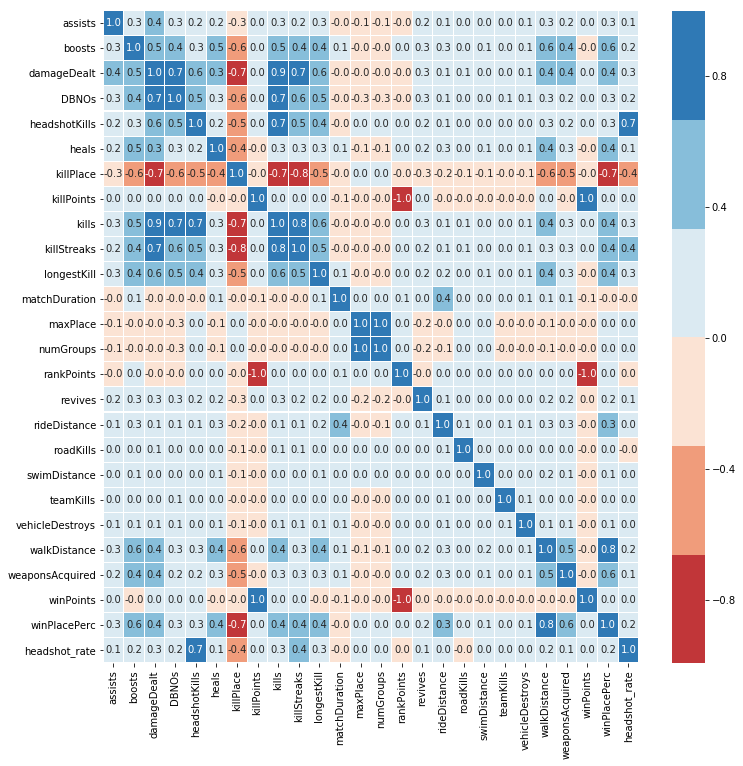

In [19]:
f,ax = plt.subplots(figsize=(12, 12))
train_corr = train.corr()
ax = sns.heatmap(train_corr, linewidths=.1, cmap=sns.color_palette("RdBu"), annot=True, fmt= '.1f')

This describes the correlation between features. The highest ones for 'winPlacePerc' can be found below.

In [21]:
train_corr['winPlacePerc'].nlargest()

winPlacePerc       1.000000
walkDistance       0.810761
boosts             0.634292
weaponsAcquired    0.584610
damageDealt        0.440428
Name: winPlacePerc, dtype: float64

In [29]:
train_corr['winPlacePerc'].nsmallest()

killPlace       -0.718707
matchDuration   -0.005209
winPoints        0.007440
rankPoints       0.013145
killPoints       0.013235
Name: winPlacePerc, dtype: float64

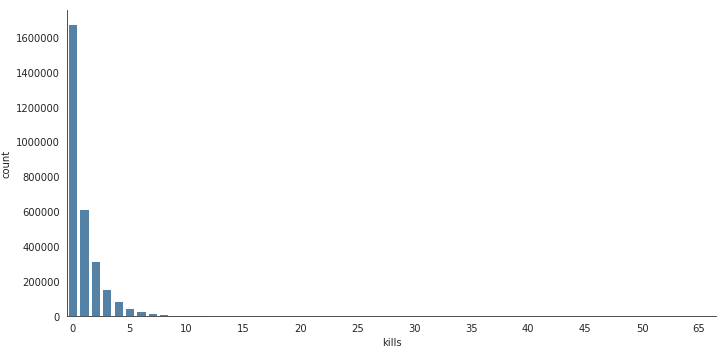

In [22]:
with sns.axes_style('white'):
    #train.loc[train['kills'] > train['kills'].quantile(0.99)] = '8+'
    g = sns.factorplot("kills", data=train, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)

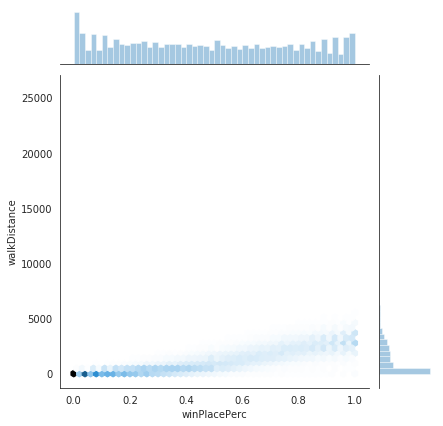

In [34]:
with sns.axes_style('white'):
    g = sns.jointplot("winPlacePerc", "walkDistance", train, kind='hex')

In [23]:
first_kills = train.loc[train['kills']>train['kills'].quantile(0.50)]

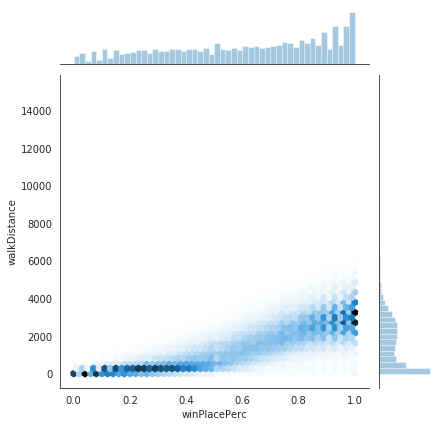

In [24]:
with sns.axes_style('white'):
    g = sns.jointplot("winPlacePerc", "walkDistance", first_kills, kind='hex')

In [52]:
group_data = train.groupby('groupId').sum()

### Anomalies in training data

As not everyone plays fair, there might be data from players who have unfair playing methods:
1. 100% headshot rate for several kills
2. Nearly no ride distance but road kills
3. Kills without movement

#### 1. 100% headshot rate for several kills

In [16]:
train['headshot_rate'] = np.where(train['kills'] > 0, train['headshotKills']/train['kills'], 0)

In [17]:
train[(train['headshot_rate']==1) & (train['kills']>9)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0.000000,0.0,0.000000,0.0,0.0,2939.0,5.0,0.0,0.8462,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,4720.000000,0.0,0.000000,0.0,0.0,3422.0,8.0,1560.0,1.0000,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,0.000000,0.0,0.000000,0.0,0.0,2105.0,5.0,1587.0,1.0000,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,5187.000000,0.0,0.000000,2.0,0.0,2761.0,7.0,1519.0,0.9630,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,1018.000000,0.0,0.000000,0.0,0.0,2458.0,4.0,1562.0,1.0000,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,5246.000000,0.0,0.000000,0.0,0.0,2932.0,4.0,0.0,1.0000,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,408.899994,0.0,0.000000,0.0,0.0,2450.0,7.0,1468.0,1.0000,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,2048.000000,0.0,0.000000,0.0,0.0,3915.0,5.0,0.0,1.0000,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,0.000000,0.0,0.000000,0.0,0.0,3108.0,7.0,1500.0,1.0000,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,0.000000,0.0,140.800003,0.0,0.0,2339.0,4.0,0.0,1.0000,1.0


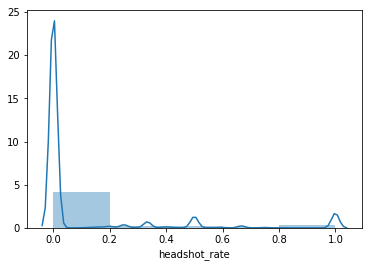

In [18]:
sns.distplot(train['headshot_rate'], bins=5)

Unclear if these players are cheating, leaving them in the dataset.

#### 2. Nearly no ride distance but road kills

In [13]:
train[(train['rideDistance']<10) & (train['roadKills']>2)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
60508,62b624830aea23,ccc1caa893028a,98249433317a6d,0,3,545.400024,1,0,5,8,...,0.0,0.0031,4.0,238.899994,0.0,0.0,1289.0,2.0,0.0,0.6170
201586,ef82d1b6524414,3fed7386635a22,a90925f064af69,0,1,300.000000,0,0,1,12,...,0.0,0.0086,3.0,17.879999,0.0,0.0,3766.0,2.0,0.0,0.6296
471329,aa7e78882e667d,519d050ae0c496,df3223d5b94550,0,0,800.000000,0,0,0,3,...,0.0,0.0415,8.0,244.800003,0.0,0.0,5470.0,0.0,1536.0,0.5286
1575207,e45583ef0367d0,20dd696c27be89,c65248c240fc36,0,0,300.000000,0,0,0,9,...,0.0,0.0203,3.0,166.500000,0.0,0.0,1465.0,0.0,0.0,0.2917
2466988,ac8a6bc9bb4695,c5692358a5f04e,72418857156fac,0,1,483.799988,0,0,1,6,...,0.0,0.0213,4.0,25.469999,0.0,0.0,1653.0,2.0,0.0,0.4773
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.000000,0,0,0,1,...,0.0,0.0050,14.0,5.297000,0.0,0.0,1277.0,0.0,1371.0,0.4286


These are highly suspicious. All of them will be dropped.

In [14]:
suspicious = train[(train['rideDistance']<10) & (train['roadKills']>2)].Id

In [15]:
for i in suspicious:
    train.drop(train[train['Id'] == i].index, inplace=True)

#### 3. Kills without movement

In [8]:
train[(train['walkDistance']==0) & (train['kills']>9)].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.8947
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.0,0,4,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.6000
36345,5cf4f90e24e26f,f84b7639c369c7,9c8962b58bb3e3,3,0,1114.0,0,0,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1500.0,1.0000
57878,4cf42a5d238351,d6feec32a85a37,ed092b499ac27d,7,0,1458.0,0,6,0,8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,37.0,1500.0,0.2000
59565,6cc34d6af024d4,33646e41ee63a6,35e7d750e442e2,3,0,1010.0,0,2,8,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.6429


Most likely these are cheaters and therefore dropped from the dataframe

In [11]:
suspicious_walk = train[(train['walkDistance']==0) & (train['kills']>9)].Id
suspicious_walk.describe()

count                170
unique               170
top       f6544081bfe066
freq                   1
Name: Id, dtype: object

In [12]:
for i in suspicious_walk:
    train.drop(train[train['Id'] == i].index, inplace=True)

### Save the data as csv for further processing

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2939563 entries, 0 to 2939738
Data columns (total 30 columns):
Id                 object
groupId            object
matchId            object
assists            int32
boosts             int32
damageDealt        float32
DBNOs              int32
headshotKills      int32
heals              int32
killPlace          int32
killPoints         int32
kills              int32
killStreaks        int32
longestKill        float32
matchDuration      int32
matchType          object
maxPlace           int32
numGroups          int32
rankPoints         float32
revives            float32
rideDistance       float32
roadKills          float32
swimDistance       float32
teamKills          float32
vehicleDestroys    float32
walkDistance       float32
weaponsAcquired    float32
winPoints          float32
winPlacePerc       float32
headshot_rate      float64
dtypes: float32(13), float64(1), int32(12), object(4)
memory usage: 414.9+ MB
